In [15]:
from src.experiment import ExperimentInstance
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import tensorflow as tf
import random


In [16]:
dataset = 'ETTh2'

In [17]:
parameters = {"ETTh2": {'dataset': {'name': "ETTh2", 
                          'params': {'seq_len': 72, 'pred_len': 72, 'shift': 24, 'crossval': False}}, 
              'selection': {'name': 'NoSelection'}, 
              'model': {'name': 'parallel_xgb', 
                        'params': {'max_depth': 2, 'n_estimators': 10, 'type': 'xgboost'}}},
            }

In [18]:
seed = 123
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)
experiment = ExperimentInstance(parameters[dataset])
experiment.run()

{'dataset': {'name': 'ETTh2', 'params': {'seq_len': 72, 'pred_len': 72, 'shift': 24, 'crossval': False}}, 'selection': {'name': 'NoSelection'}, 'model': {'name': 'parallel_xgb', 'params': {'max_depth': 2, 'n_estimators': 10, 'type': 'xgboost'}}}


,mean_squared_error,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2,mean_absolute_error_valid,root_mean_squared_error_valid,mean_squared_error_valid,dataset,dataset_name,...,dataset_params_crossval,selection_name,model_name,model_params_max_depth,model_params_n_estimators,model_params_type,features,selected_features,duration,code
0,52.716168,7.26059,5.687316,0.171949,-0.957775,5.96517,7.67252,58.867557,ETTh2,ETTh2,...,False,NoSelection,parallel_xgb,2,10,xgboost,"[HUFL t-72, HULL t-72, MUFL t-72, MULL t-72, L...","[MUFL t-72, MULL t-72, target t-72, HUFL t-71,...",110.759422,cc615afc6b62961239741e4ee298a701


## Error maps

In [5]:
inputs, true, preds = experiment.raw_results_[-1]


mse = (true-preds)**2
results = pd.DataFrame({'Month': dates.month, 'Hour': dates.hour, 'Error': mse}).iloc[:-1].groupby(['Month', 'Hour']).mean().reset_index()
heatmap = results.pivot("Hour", "Month", "Error").apply(np.sqrt)

ValueError: not enough values to unpack (expected 4, got 3)

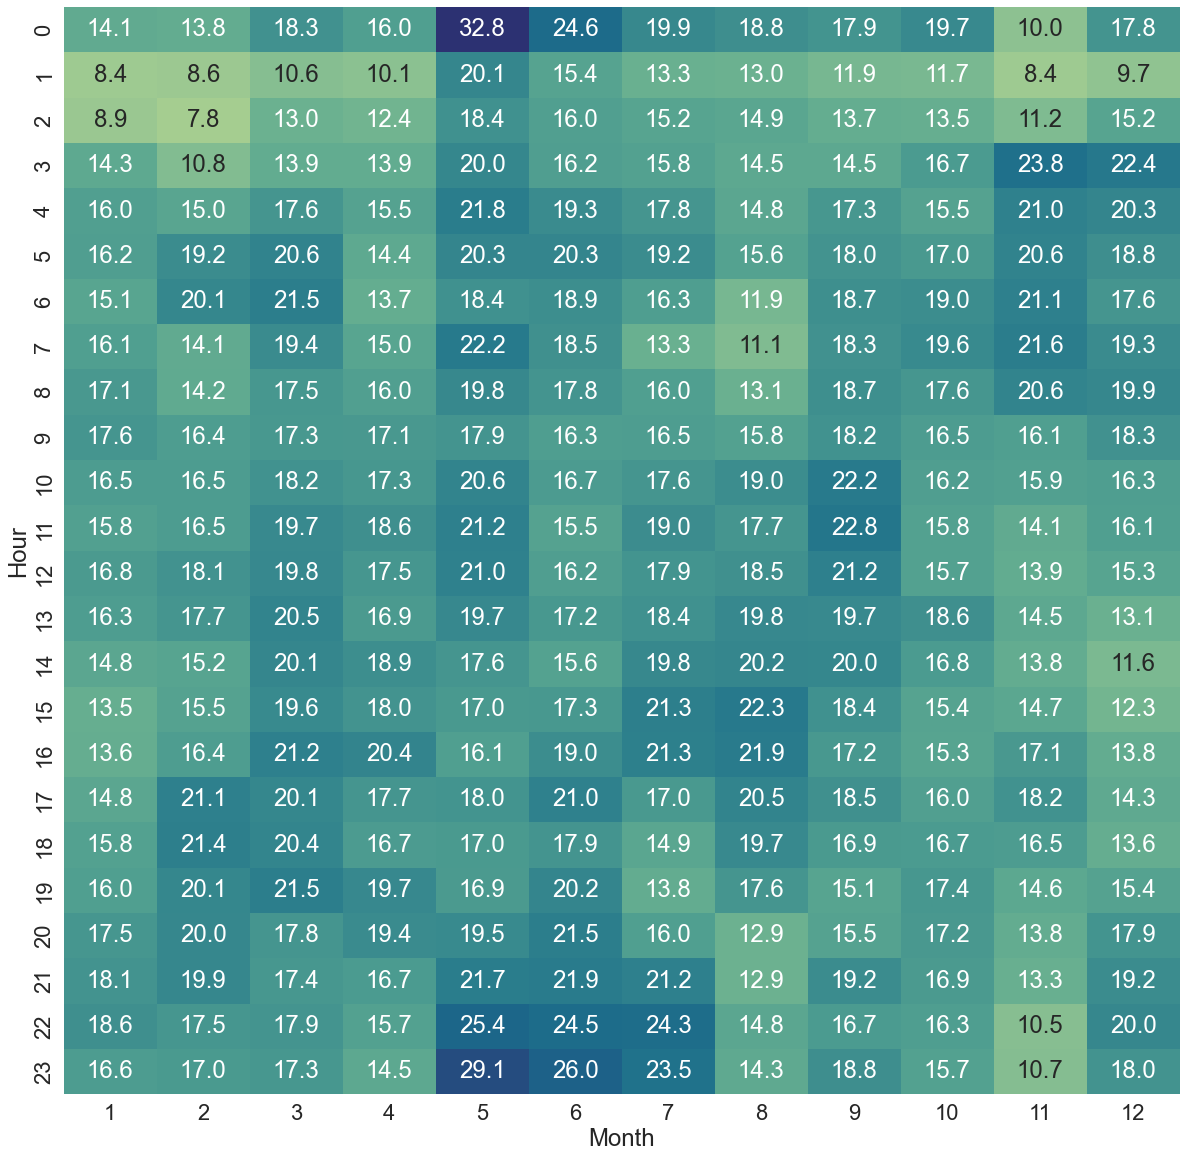

In [ ]:
sns.set(font_scale=2)
plt.subplots(figsize=(20,20))
g = sns.heatmap(heatmap, annot=True, cmap="crest", fmt=".1f", cbar=False)
fig = g.get_figure()
fig.savefig(f"figures/ErrorMaps/{dataset.capitalize()}TSL.png") 

## Best/Worst predictions

In [19]:
inputs, true, preds = experiment.raw_results_[-1]

preds = preds.reshape(-1, 72)
true = true.reshape(-1, 72)
mse_reshaped = np.sqrt(((true-preds)**2).mean(axis=1))
min_index = np.argmin(mse_reshaped)
best_preds = preds[min_index]
best_trues = true[min_index]

max_index = np.argmax(mse_reshaped)

worst_preds = preds[max_index]
worst_trues = true[max_index]

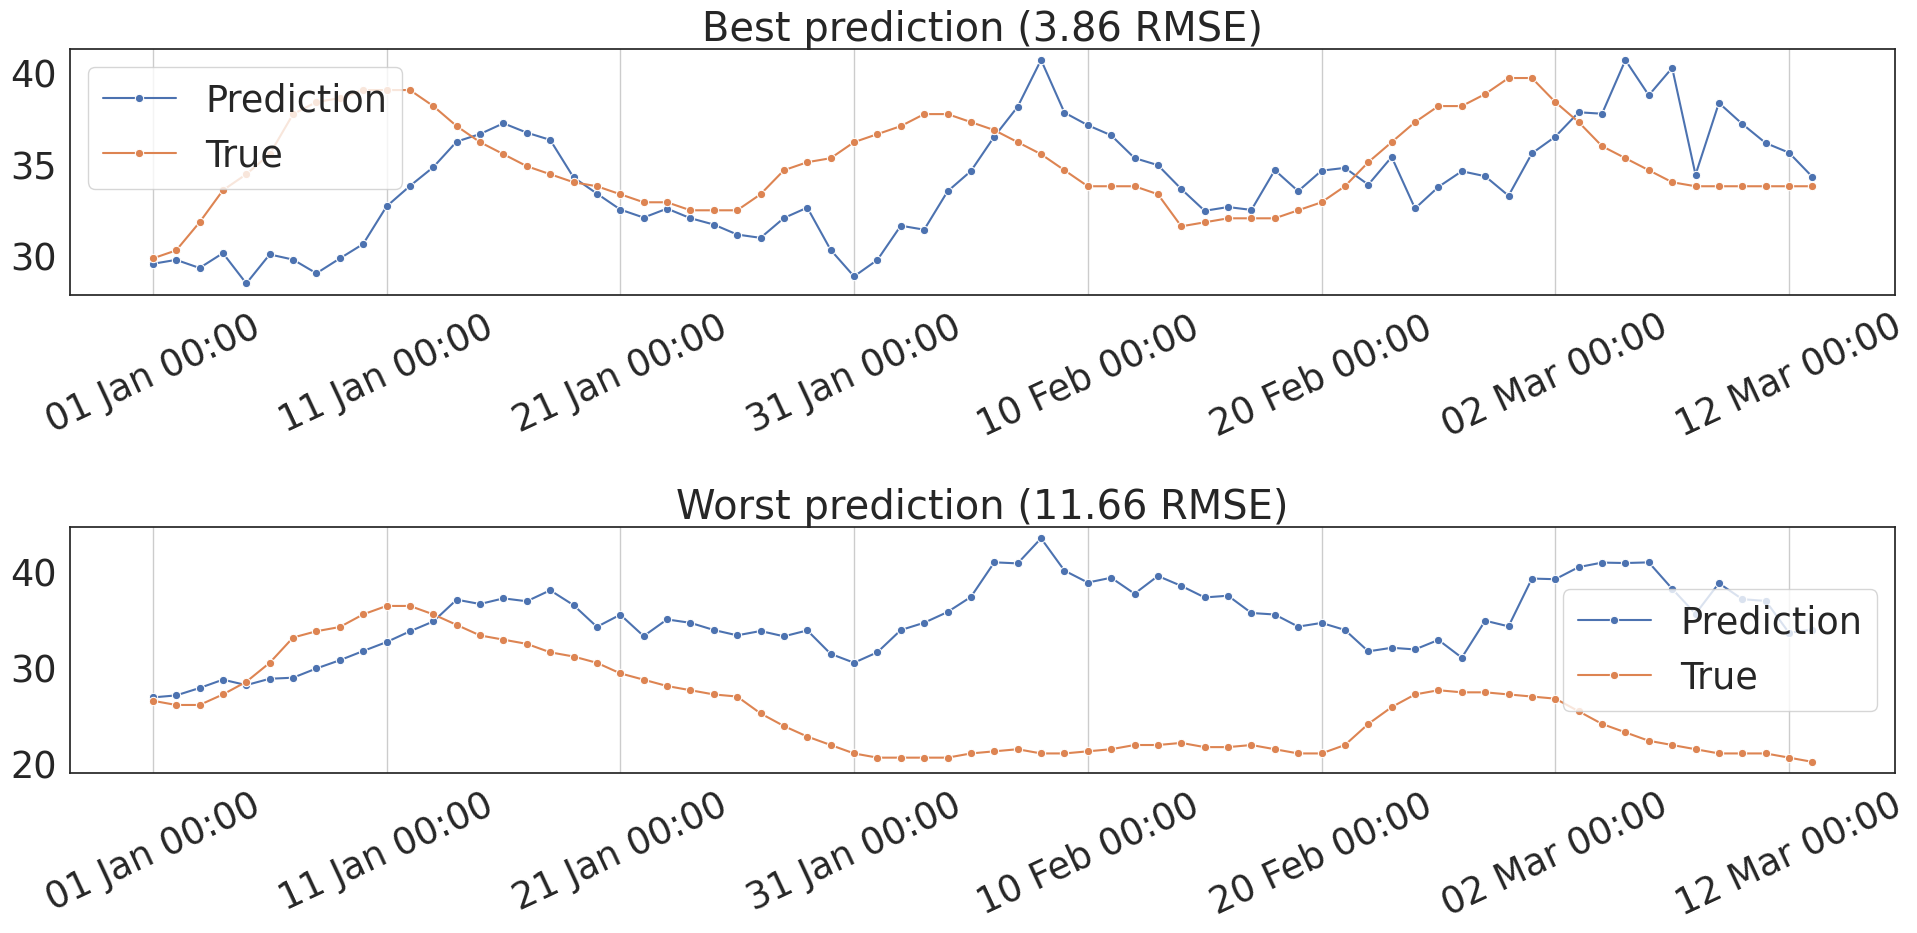

In [20]:
sns.set(style='white', font_scale=2.4)
fig, ax = plt.subplots(2, 1, figsize=(20,10))
sns.lineplot(x=np.arange(72), y=best_preds, ax=ax[0], label='Prediction', marker='o')
sns.lineplot( x=np.arange(72),y=best_trues, ax=ax[0], label='True', marker='o')
ax[0].xaxis.grid() # vertical lines
ax[0].set_title(f'Best prediction ({round(mse_reshaped[min_index], 2)} RMSE)')



sns.lineplot(x=np.arange(72), y=worst_preds, ax=ax[1], label='Prediction', marker='o')
sns.lineplot(x=np.arange(72), y=worst_trues, ax=ax[1], label='True', marker='o')
ax[1].xaxis.grid() # vertical lines
ax[1].set_title(f'Worst prediction ({round(mse_reshaped[max_index], 2)} RMSE)')



date_form = DateFormatter("%d %b %H:00")
ax[0].xaxis.set_major_formatter(date_form)

ax[1].xaxis.set_major_formatter(date_form)


for label in ax[0].get_xticklabels():
    label.set_ha("center")
    label.set_rotation(25)

for label in ax[1].get_xticklabels():
    label.set_ha("center")
    label.set_rotation(25)

plt.tight_layout()

